In [1]:
"""Original contents of TCs-under-SAI/analysis/src/interpolate.py"""
import os
import sys
import glob
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from numba import float32, float64, guvectorize

def pressure_from_hybrid(ds, cell_interface=False):
    """Calculate atmospheric pressure from hybrid coefficients

    ds : xr.Dataset
        dataset from which to obtain hybrid coefficients, 
        reference and surface pressure
    cell_interface : Bool
        if True, calculate pressure at vertical cell interfaces, 
        else use midpoints (default)

    returns:
    xr.DataArray : 3D atmospheric pressure, same units as ds.PS
    """

    if cell_interface:
        P = ds.hyai * ds.P0 + ds.hybi * ds.PS
    else:
        P = ds.hyam * ds.P0 + ds.hybm * ds.PS
    P = P.assign_attrs(ds.PS.attrs)
    P.attrs.update({'long_name':'Pressure'})
    
    return P


@guvectorize(
    "(float64[:], float64[:], float64[:], float32[:])",
    " (n), (n), (m) -> (m)",
    nopython=True, target='parallel'
)
def interp1d_gu(f, x, xi, out):
    """Interpolate one-dimensional field f(x) to xi in ln(x) coordinates."""
    i, imax, x0, f0 = 0, len(xi), x[0], f[0]
    while (xi[i] < x0) and (i < imax):
        out[i] = np.nan      
        i = i + 1 
    for x1,f1 in zip(x[1:], f[1:]):
        while (xi[i] <= x1) and (i < imax):
            out[i] = (f1-f0)/np.log(x1/x0)*np.log(xi[i]/x0)+f0
            i = i + 1
        x0, f0 = x1, f1
    while i < imax:
        out[i] = np.nan
        i = i + 1


def interpolate(da, p, pi, dim, chunks={}):
    """Apply 1D interpolation function on xarray objects

    input:
    da : xr.DataArray
        field to interpolate
    p : xr.DataArray
        pressure
    pi : ArrayLike
        new pressure levels (1D)
    dim : Str
        dimension used for interpolation
    chunks : dict
        passed to da.chunk. if empty, existing chunks are retained

    returns:
    xr.DataArray
        da interpolated to new pressure levels
        dim is replaced by 'plev'
    """
    pi = xr.DataArray(name='plev', data=sorted(pi), dims='plev')
    dims = list(da.dims)
    dims[dims.index(dim)] = pi.dims[0]
    da = da.chunk(chunks)
    p = p.chunk(chunks)
    
    interped = xr.apply_ufunc(
        interp1d_gu, da, p, pi,
        input_core_dims=[[dim],[dim],pi.dims],
        output_core_dims=[pi.dims],
        exclude_dims=set((dim,)),
        dask='parallelized',
        on_missing_core_dim='drop'
    ).transpose(*dims).assign_coords({pi.name:pi}).assign_attrs(da.attrs)
    interped.name = da.name

    return interped

In [2]:
ds = xr.open_dataset("/projects/0/nwo2021025/archive/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001"
                    +"/atm/hist/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001.cam2.h0.2003-01.nc")
ds.Q

<xarray.DataArray 'Q' (time: 1, lev: 30, lat: 768, lon: 1152)> Size: 106MB
[26542080 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 240B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time     (time) object 8B 2003-02-01 00:00:00
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

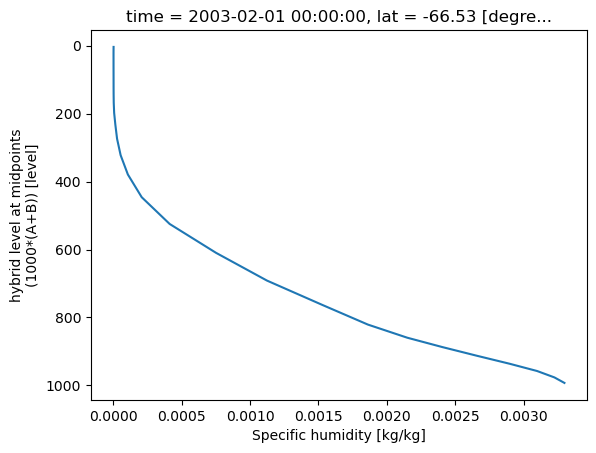

In [5]:
ds_col = ds.isel(time=0, lat=100, lon=0)
ds_col.Q.plot(y='lev',yincrease=False, yscale='linear')

We now wish to integrate Q from Pmin = 400 hPa to Pmax = 700 hPa.  
Testing a function on one column of data: 

In [6]:
def integrate(f, pi, p_min, p_max):
    """ Vertically integrate field f from p_min to p_max in pressure coordinates.
    """
    integral = 0.0
    nlev = len(f)
    for k in range(nlev):
        p_bnd = pi[k], pi[k+1]
        dp = min(p_bnd[1],p_max) - max(p_bnd[0],p_min)
        if dp <= 0:
            continue
        integral += f[k] * dp
    return integral

ds_col = ds.isel(time=0, lat=100, lon=0)
P = pressure_from_hybrid(ds_col, cell_interface=False)
Pi = pressure_from_hybrid(ds_col, cell_interface=True)
Q = ds_col.Q

print(f"{integrate(xr.ones_like(Q), Pi, 40000, 70000) = :.1f} (should be 30000)")
print(f"{integrate(xr.ones_like(Q)*2, Pi, 40000, 70000) = :.1f} (should be 60000)")
print(f"{integrate(Q, Pi, Pi.min(), Pi.max())/9.81 = :.1f} (should be {ds_col.TMQ:.1f})")

integrate(xr.ones_like(Q), Pi, 40000, 70000) = 30000.0 (should be 30000)
integrate(xr.ones_like(Q)*2, Pi, 40000, 70000) = 60000.0 (should be 60000)
integrate(Q, Pi, Pi.min(), Pi.max())/9.81 = 8.3 (should be 8.3)


In [7]:
"""new content"""

@guvectorize(
    "(float32[:], float64[:], float64, float64, float64[:])",
    " (n), (m), (), () -> ()",
    nopython=True, target='parallel'
)
def integrate1d_gu(f, pi, p_min, p_max, out):
    """Vertically integrate field f from p_min to p_max in pressure coordinates."""
    out[0] = 0.0
    nlev = len(f)
    for k in range(nlev):
        p_bnd = pi[k], pi[k+1]
        dp = min(p_bnd[1],p_max) - max(p_bnd[0],p_min)
        if dp <= 0:
            continue
        out[0] += f[k] * dp

pi = pressure_from_hybrid(ds, cell_interface=True)
out1 = xr.apply_ufunc(integrate1d_gu, xr.ones_like(ds.Q)*2, pi, 40000.0, 70000.0,
               input_core_dims=[['lev'],['ilev'],[],[]],
               output_core_dims=[[]],
               dask='parallelized',
               on_missing_core_dim='drop')
out2 = xr.apply_ufunc(integrate1d_gu, ds.Q, pi, pi.min(), pi.max(),
               input_core_dims=[['lev'],['ilev'],[],[]],
               output_core_dims=[[]],
               dask='parallelized',
               on_missing_core_dim='drop')

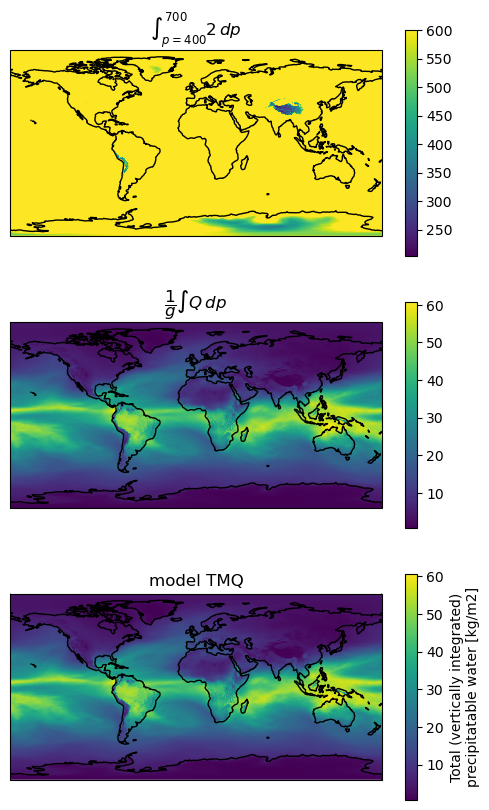

In [8]:
fig,axs = plt.subplots(3,1,figsize=(6,10),subplot_kw={'projection':ccrs.PlateCarree()})

(out1/100).plot(ax=axs[0],transform=ccrs.PlateCarree())
(out2/9.8).plot(ax=axs[1],transform=ccrs.PlateCarree())
ds.TMQ.plot(ax=axs[2],transform=ccrs.PlateCarree())
axs[0].set_title(r"$\int_{p=400}^{700}2\,dp$")
axs[1].set_title(r"$\dfrac{1}{g}\int Q\,dp$")
axs[2].set_title('model TMQ')
for ax in axs:
    ax.coastlines()

Text(0.5, 1.0, '($\\dfrac{1}{g}\\int Q\\,dp$ - model TMQ) / model TMQ')

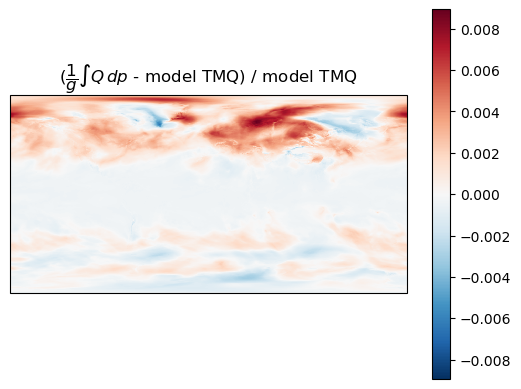

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
(((out2/9.81)-ds.TMQ)/ds.TMQ).plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_title(r"($\dfrac{1}{g}\int Q\,dp$ - model TMQ) / model TMQ")

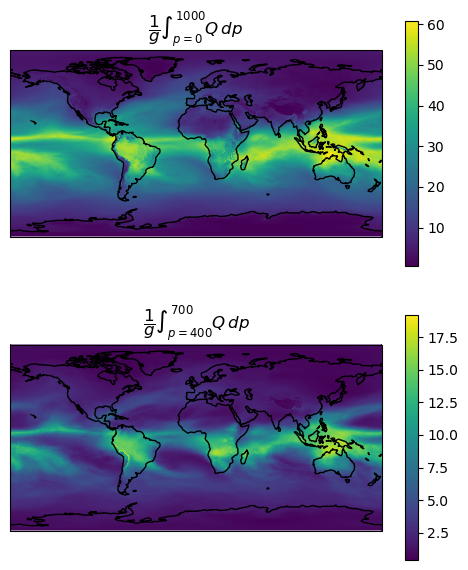

In [20]:
# added to script, let's test it again
import interpolate

pi = interpolate.pressure_from_hybrid(ds, cell_interface=True)
TMQ = interpolate.integrate(ds.Q, pi, pi.min(), pi.max()) / 9.81
Qmid = interpolate.integrate(ds.Q, pi, 40000, 70000) / 9.81

fig,axs = plt.subplots(2,1,figsize=(6,7),subplot_kw={'projection':ccrs.PlateCarree()})
TMQ.plot(ax=axs[0],transform=ccrs.PlateCarree())
Qmid.plot(ax=axs[1],transform=ccrs.PlateCarree())
axs[0].set_title(r"$\dfrac{1}{g}\int_{p=0}^{1000} Q\,dp$")
axs[1].set_title(r"$\dfrac{1}{g}\int_{p=400}^{700} Q\,dp$")
for ax in axs:
    ax.coastlines()